## Fine-tuning using human RDMs

In [3]:
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
from skimage.transform import resize

def loadmat(matfile):
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

def loadnpy(npyfile):
    return np.load(npyfile)

def load(data_file):
    root, ext = os.path.splitext(data_file)
    return {'.npy': loadnpy,
            '.mat': loadmat
            }.get(ext, loadnpy)(data_file)

human_fmri = loadmat('../Training_Data/118_Image_Set/target_fmri.mat')
human_fmri['EVC_RDMs'].shape

(15, 118, 118)

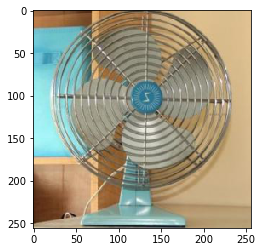

In [4]:
def crop_center(img, cropx, cropy):
    x,y,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)   
    return img[startx:startx+cropx,starty:starty+cropy]

def resize_img(img, target_size):
    ratios = [float(target_size[i]) / img.shape[i] for i in range(len(target_size))]
    larger_ratio = max(ratios)
    new_shape = [float(larger_ratio) * img.shape[i] for i in range(len(target_size))]
    
    img = resize(img, (int(np.round(new_shape[0])), 
                       int(np.round(new_shape[1]))),
                 mode='reflect')
    
    # crop
    img = crop_center(img, target_size[0], target_size[1])
    return img

def load_image(filename, target_size=(256,256)):
    img = image.load_img(filename, target_size=None)
    img = image.img_to_array(img)
    img = 1./255 * img
    img = resize_img(img, target_size=target_size)
    return img

img = load_image('../Training_Data/118_Image_Set/118images/image_118.jpg')
plt.imshow(img)

In [5]:
evc_y = []
evc_x = []
image_path = '../Training_Data/118_Image_Set/118images/image_{:03d}.jpg'
image_cache = {}

for sub_idx, subject_fmri in enumerate(human_fmri['EVC_RDMs']):
    print('Processing subject {} of {} ...'.format(sub_idx+1, len(human_fmri["EVC_RDMs"])))
    
    for img_i in range(subject_fmri.shape[0]):
        for img_j in range(img_i, subject_fmri.shape[1]):
            evc_y.append(subject_fmri[img_i][img_j])
            img_i_path = image_path.format(img_i+1)
            img_j_path = image_path.format(img_j+1)
            evc_x.append([img_i_path, img_j_path])
            
evc_y = np.array(evc_y)
evc_x = np.array(evc_x)

evc_shape = human_fmri['EVC_RDMs'].shape
expected_samples = (np.prod(evc_shape) + evc_shape[0] * evc_shape[2])//2

assert evc_y.shape[0] == expected_samples
assert evc_x.shape[0] == evc_y.shape[0]
evc_x.shape, evc_y.shape

Processing subject 1 of 15 ...
Processing subject 2 of 15 ...
Processing subject 3 of 15 ...
Processing subject 4 of 15 ...
Processing subject 5 of 15 ...
Processing subject 6 of 15 ...
Processing subject 7 of 15 ...
Processing subject 8 of 15 ...
Processing subject 9 of 15 ...
Processing subject 10 of 15 ...
Processing subject 11 of 15 ...
Processing subject 12 of 15 ...
Processing subject 13 of 15 ...
Processing subject 14 of 15 ...
Processing subject 15 of 15 ...


((105315, 2), (105315,))

In [35]:
train_x, val_x, train_y, val_y = train_test_split(evc_x, evc_y, test_size=0.1, random_state=17)
train_x.shape, val_x.shape

def data_generator(data_x, data_y, batch_size=1, n_timesteps=10):
    n_batches = len(data_x) // batch_size
    
    while True:
        np.random.shuffle(data_x)
        np.random.shuffle(data_y)
        
        for batch_idx in range(n_batches):
            batch_x1 = []
            batch_x2 = []
            batch_y = []
            for idx in range(batch_idx*batch_size, (batch_idx+1)*batch_size):
                batch_x1.append([load_image(data_x[idx][0])] * n_timesteps)
                batch_x2.append([load_image(data_x[idx][1])] * n_timesteps)
                batch_y.append([data_y[idx]])
                
            batch_x1 = np.array(batch_x1)
            batch_x2 = np.array(batch_x2)
            batch_y = np.array(batch_y)
            yield [batch_x1, batch_x2], batch_y
            
train_generator = data_generator(train_x, train_y, batch_size=1)

In [36]:
images, labels = next(train_generator)
images[0].shape

(1, 10, 256, 256, 3)

In [8]:
labels

array([[ 0.24339289]])

In [37]:
from keras.models import Model
from keras.layers import Flatten, Dense, TimeDistributed, LSTM
from keras.layers import Input, Masking, Lambda
from keras.layers import Bidirectional, concatenate
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras import backend as K
import prednet_model
import utils

def crop(dimension, start=None, end=None, stride=1, name=None):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    # See https://github.com/keras-team/keras/issues/890
    def func(x):
        if dimension == 0:
            return x[start:end:stride]
        if dimension == 1:
            return x[:, start:end:stride]
        if dimension == 2:
            return x[:, :, start:end:stride]
        if dimension == 3:
            return x[:, :, :, start:end:stride]
        if dimension == 4:
            return x[:, :, :, :, start:end:stride]
    return Lambda(func, name=name)

def lstm_layer(tensor, mask_value, hidden_dims, 
               dropout, name, bidirectional=False, 
               return_sequences=False):
    x = TimeDistributed(Flatten(), name='flatten_' + name)(tensor)
    if mask_value is not None:
        x = Masking(mask_value=mask_value)(x)
    for dim in hidden_dims:
        if bidirectional:
            x = Bidirectional(LSTM(dim, return_sequences=return_sequences, dropout=dropout), 
                              merge_mode='concat', name='BiLSTM_' + name)(x)
        else:
            x = LSTM(dim, return_sequences=return_sequences, dropout=dropout)(x)
    return x

def prednet_rdm(input_shape, hidden_dims, drop_rate=0.5, 
                mask_value=None, train=False, **config):
    
    if config is None:
        config = {}
        
    config['input_width'] = input_shape[1]
    config['input_height'] = input_shape[2]
    config['input_channels'] = input_shape[3]
        
    prednet = prednet_model.create_model(train=train, output_mode='representation', **config)
    
    prednet_layer = prednet.layers[1]
    for l in prednet.layers:
        l.trainable = train
        
    image_a = Input(shape=input_shape)
    image_b = Input(shape=input_shape)

    # The vision model will be shared, weights and all
    out_a = prednet(image_a)
    out_b = prednet(image_b)
    
    # flat_shapes = [61440, 245760, 122880, 61440]
    out_a = crop(2, start=-61440)(out_a)
    out_b = crop(2, start=-61440)(out_b)
    out_a = lstm_layer(out_a, mask_value, hidden_dims, drop_rate, 
                       'lstm_a', return_sequences=False)
    out_b = lstm_layer(out_b, mask_value, hidden_dims, drop_rate, 
                       'lstm_b', return_sequences=False)

    concatenated = concatenate([out_a, out_b])
    out = Dense(1)(concatenated)

    model = Model([image_a, image_b], out)
    return model

def train(config_name, train_x, train_y, val_x, val_y, hidden_dims=[32], 
          epochs=10, use_multiprocessing=False, workers=0, batch_size=1,
          dropout=0.5, stopping_patience=3, base_results_dir='./results',
          input_shape=[10, 256, 256, 3], mask_value=None,
          data_format=K.image_data_format(), **config):
    
    train_generator = data_generator(train_x, train_y, batch_size=batch_size)
    val_generator = data_generator(val_x, val_y, batch_size=batch_size)
    
    results_dir = utils.get_create_results_dir(config_name, base_results_dir)
    model = prednet_rdm(input_shape, hidden_dims, drop_rate=dropout, 
                        mask_value=mask_value, **config)
    checkpoint_path = os.path.join(results_dir, 'finetuned_rdm.hdf5')
    csv_path = os.path.join(results_dir, 'finetuned_rdm.log')

    model.compile(loss='mean_squared_error', optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    model.summary()
    
    json_file = os.path.join(results_dir, 'finetuned_rdm.json')
    json_string = model.to_json()
    with open(json_file, "w") as f:
        f.write(json_string)
    
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, 
                                   verbose=1, save_best_only=True)
    
    csv_logger = CSVLogger(csv_path)
    stopper = EarlyStopping(monitor='val_loss', 
                            patience=stopping_patience, 
                            verbose=0, mode='auto')
    
    model.fit_generator(train_generator,
                        len(train_x),
                        epochs=epochs,
                        validation_data=val_generator,
                        validation_steps=len(val_x),
                        callbacks=[checkpointer, csv_logger, stopper],
                        use_multiprocessing=use_multiprocessing,
                        workers=workers)

config = {
    'n_timesteps': 10,
    'batch_size': 1,
    'stateful': False,
    'input_channels': 3, 
    'input_height': 256,
    'input_width': 256,
    'rescale': 1./255,
    'shuffle': False,
    'workers': 1,
    # RESULTS
    'base_results_dir': './results/',
}

train('prednet_rdm', train_x, train_y, val_x, val_y, **config)

Layer 0 shape: (256, 256, 3) (196608)
Layer 1 shape: (128, 128, 48) (786432)
Layer 2 shape: (64, 64, 96) (393216)
Layer 3 shape: (32, 32, 192) (196608)
Layer 0 shape: (256, 256, 3) (196608)
Layer 1 shape: (128, 128, 48) (786432)
Layer 2 shape: (64, 64, 96) (393216)
Layer 3 shape: (32, 32, 192) (196608)
Layer 0 shape: (256, 256, 3) (196608)
Layer 1 shape: (128, 128, 48) (786432)
Layer 2 shape: (64, 64, 96) (393216)
Layer 3 shape: (32, 32, 192) (196608)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 10, 256, 256, 0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 10, 256, 256, 0                                            
_________________________________________________

KeyboardInterrupt: 